#### Questions to ask
 - Feature scaling to train and test, seperately or together
 - Same question for word vectorizers
 - Diagnosing from learning curves
 - GBDT

#### Next Steps

 - Commit
 - fine tune the city wise model
 - Removing Outliers
 
 - Understand all your features, gather more domain knowledge, read discussion forums, Consolidate the climate features into some form common metric, do some visualisations over features and y labels

complete ensemble videos
 - try an XG Boost regression or CAT Boost
 
Later
 - Use imputation for null values

#### Results from Experiments
 - Directly using week number as a feature didn't do good, so we engineered the month and it did better
 - Using month without or with one hot encoding gives mixed results under different circumstances
 - adding the city boolean has done a good improvement to the model
 - Both L1 and L2 seem to improve the model 
 - Some improvement is also acheived through feature selection using RFE, but doing regularization on top of it can only improve things so much
 - Median Absolute Deviation is slightly better than mean, indicating the presence of outliers
 - Clipping the negative predictions to zeros results in a minute improvement

#### importing the relevant packages and loading the data

In [92]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

X = pd.read_csv("dengue_features_train.csv")
y = pd.read_csv("dengue_labels_train.csv")
test = pd.read_csv("dengue_features_test.csv")

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
def mape(Y_test, Y_pred, epsilon = 1):
    return np.mean(np.abs((Y_test - Y_pred + epsilon) / (Y_test + epsilon))) * 100

#### Data Preprocessing

In [69]:
# Converting the city column into a boolean, since we just have two cities
# To be used later
is_sj = X.city == 'sj'

In [70]:
def extract_month(s):
    return int(s[5:7])

months = X.week_start_date.apply(extract_month)

#### Train Test Split
We shall split our dataset based on time stamps as we are required to make predictions for the future.

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
# Removing the dates info for now
X.drop(['city', 'year', 'weekofyear', 'week_start_date'], axis=1, inplace=True)

# Dropping the rows with null values for now
X.dropna(inplace=True)
# Selecting y values corresponding to the filtered X values
y = y.total_cases.loc[X.index]

# Standardizing the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X)

X['is_sj'] = is_sj.loc[X.index]

sliced_months = months.loc[X.index]

# Month one hot features
month_features = pd.get_dummies(sliced_months)
X = X.join(month_features)

# Alternatively use months as a discrete feature
X = X.join(sliced_months)

In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, shuffle = False)

#### Baseline Model

In [78]:
lr = LinearRegression()

lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

In [79]:
mean_absolute_error(Y_test, Y_pred)

10.872447734918156

In [80]:
mape(Y_test, Y_pred)

187.36778402784176

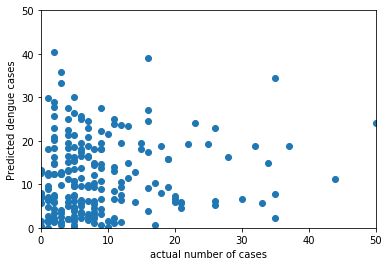

In [81]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### Random Model

In [54]:
y_p = np.full(len(Y_test), np.mean(Y_train))

In [55]:
mean_absolute_error(Y_test, y_p)

18.120148312940305

In [56]:
mape(Y_test, y_p)

436.48118768988996

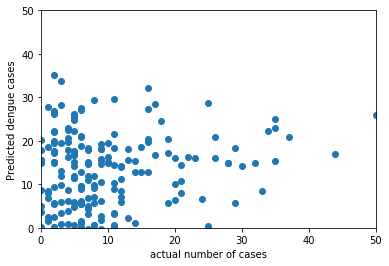

In [18]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### Recursive Feature Selection

In [57]:
from sklearn.feature_selection import RFE

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select n attributes
rfe = RFE(model, 13)
rfe = rfe.fit(X, y)
X_Select = X.loc[:, rfe.support_]

# Split based on the newly selected features and train and test again
X_train, X_test, Y_train, Y_test = train_test_split(X_Select, y, shuffle = False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

mape(Y_test, Y_pred)

189.857139044318

In [58]:
mean_absolute_error(Y_test, Y_pred)

10.581747164567757

### Regularization

#### L2

In [82]:
from sklearn import linear_model

In [83]:
clf = linear_model.Ridge(alpha = 44)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

8.64085504665708

In [84]:
mape(Y_test, Y_pred)

151.67812591948748

In [85]:
median_absolute_error(Y_test, Y_pred)

6.000368778284871

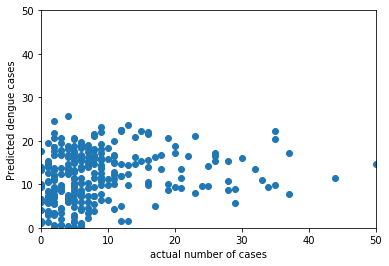

In [63]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### Submission 1

In [64]:
test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


#### L1

In [86]:
clf = linear_model.Lasso(alpha=.5)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

8.3512699596628

In [87]:
mape(Y_test, Y_pred)

151.166520411466

In [88]:
median_absolute_error(Y_test, Y_pred)

5.841368293129394

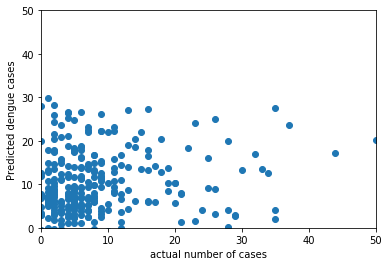

In [89]:
plt.scatter(Y_test, Y_pred)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("actual number of cases")
plt.ylabel("Predicted dengue cases")
plt.show()

#### stage for hyperparameter tuning

In [84]:
L1_mape = {}
L1_mae = {}
a = 0.1

while a < 3:
    clf = linear_model.Lasso(alpha=a)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    L1_mape[a] = mape(Y_test, Y_pred)
    L1_mae[a] = mean_absolute_error(Y_test, Y_pred)
    a += .1

In [74]:
L2_mape = {}
L2_mae = {}
a = 0

while a < 50:
    clf = linear_model.Ridge(alpha=a)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    L2_mape[a] = mape(Y_test, Y_pred)
    L2_mae[a] = mean_absolute_error(Y_test, Y_pred)
    a += 1

In [92]:
[(alpha, error) for (alpha, error) in L1_mape.items() if error < 200]

[(0.1, 194.1396435844266),
 (0.2, 189.85877040923134),
 (0.30000000000000004, 186.96033538544748),
 (0.4, 187.38134583185092),
 (0.5, 190.61127213653364),
 (0.6, 196.03889197062742),
 (0.7, 199.89787217959702)]

In [93]:
[(alpha, error) for (alpha, error) in L1_mae.items() if error < 8.3]

[(0.4, 8.266719768542329), (0.5, 8.198567106905848)]

#### Feature Selection Tuning

In [51]:
map_dict = {}
mape_dict = {}

# Recursive Feature Elimination
from sklearn.feature_selection import RFE

for n in range(2, X.shape[1]):
    # create a base classifier used to evaluate a subset of attributes
    model = LinearRegression()

    # create the RFE model and select n attributes
    rfe = RFE(model, n)
    rfe = rfe.fit(X, y)

    X_Select = X.loc[:, rfe.support_]

    X_train, X_test, Y_train, Y_test = train_test_split(X_Select, y, shuffle = False)

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mape_dict[n] = mape(Y_test, Y_pred)

    map_dict[n] = mean_absolute_error(Y_test, Y_pred)

/home/susmeet/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/susmeet/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/susmeet/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/susmeet/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

In [60]:
[(alpha, error) for (alpha, error) in mape_dict.items() if error < 200]

[(3, 178.6588117094775),
 (4, 174.88832283018104),
 (5, 172.3210908992954),
 (6, 191.73699096264804),
 (7, 180.46255071861182),
 (12, 197.21240046287113),
 (13, 196.6015450312565),
 (14, 199.3285469299827)]

In [58]:
[(alpha, error) for (alpha, error) in map_dict.items() if error < 10]

[(4, 9.88440232460372),
 (5, 9.774755345120148),
 (7, 9.867262832337078),
 (12, 9.74633959159778),
 (13, 9.697064561092054)]